In [807]:
import csv
import pickle
import re
from datetime import datetime
import numpy as np
# randn = np.random.randn
from pandas import *
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import linregress
from pylab import *
from urllib import urlopen
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from __future__ import division
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn import tree
from sklearn.externals.six import StringIO
import os
from sklearn.externals.six import StringIO  
import pydot
from sklearn.cross_validation import StratifiedKFold


## Variables Pre-processing

1 (?) - emp.var.rate = 1-value

2 (?) - euribor3m = 1/value

3 - job = 1 if student or retired, 0 if other

4 - marital = 1 if single, 0 if other

5 (?) - poutcome = 1 if success 0 if other

6 - age = ((exp^((value-47)/3))-(exp^-((value-47)/3))/2 (lowest 36-58 highest 19 and 77)

7 - campaign = 1/value

8 (?) - pdays = 1 if < 999 0 if = 999 (as "contacted before?")

9 (?) - previous = 1 if != 0

In [808]:
#math.exp(x) = e ** x
#math.expm1(x) = e ** -x
#Hyperbola centered around y axis to describe age influence (too steep)
#ex = math.exp((x-47)/3)
#emx = math.exp(-(x-47)/3)
#y = ((ex)+(emx))/2
#age = (y-1)/5000

In [809]:
bank_full = read_csv('bank-additional-full.csv', delimiter=';', header=0)
bank_full.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


In [810]:
bank = bank_full[['age','job','marital','contact','pdays','previous','poutcome','emp.var.rate','euribor3m','y']]
#bank = bank_full[['age','job','campaign','pdays','poutcome','emp.var.rate','euribor3m','y']]
#bank = bank_full[['age','job','y']]
bank.head(3)

,age,job,marital,contact,pdays,previous,poutcome,emp.var.rate,euribor3m,y
0,56,housemaid,married,telephone,999,0,nonexistent,1.1,4.857,no
1,57,services,married,telephone,999,0,nonexistent,1.1,4.857,no
2,37,services,married,telephone,999,0,nonexistent,1.1,4.857,no


In [811]:
bank['y'] = bank['y'].map({'yes': 1, 'no': 0})

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [812]:
bank['age'] =((bank['age']-47)/30) ** 2
#bank['age'][bank['age'] < 36] = abs((bank['age']-36)/19)
#bank['age'][bank['age'] >= 36] = 0
#bank['age'][bank['age'] > 58] = abs((bank['age']-58)/19)
bank['age'][bank['age'] > 1] = 1

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [813]:
bank['job'][bank['job'] == 'student'] = 1
bank['job'][bank['job'] == 'retired'] = 1
bank['job'][bank['job'] != 1] = 0

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [814]:
bank['marital'][bank['marital'] == 'single'] = 1
bank['marital'][bank['marital'] != 'single'] = 0

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [815]:
bank['contact'][bank['contact'] == 'cellular'] = 1
bank['contact'][bank['contact'] != 'cellular'] = 0

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [816]:
bank['pdays'][bank['pdays'] != 999] = 1
bank['pdays'][bank['pdays'] == 999] = 0

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [817]:
bank['previous'] = bank['previous'] / 7

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [818]:
bank['poutcome'][bank['poutcome'] == 'failure'] = 0.5
bank['poutcome'][bank['poutcome'] == 'nonexistent'] = 0
bank['poutcome'][bank['poutcome'] == 'success'] = 1

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [819]:
bank['emp.var.rate'] = abs((bank['emp.var.rate'] - 1.4) / 4.8)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [820]:
bank['euribor3m'] = 1 - (bank['euribor3m'] / 5.5)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [821]:
bank.head(5)

,age,job,marital,contact,pdays,previous,poutcome,emp.var.rate,euribor3m,y
0,0.090000,0,0,0,0,0,0,0.0625,0.116909,0
1,0.111111,0,0,0,0,0,0,0.0625,0.116909,0
2,0.111111,0,0,0,0,0,0,0.0625,0.116909,0
3,0.054444,0,0,0,0,0,0,0.0625,0.116909,0
4,0.090000,0,0,0,0,0,0,0.0625,0.116909,0


In [822]:
byes = bank[bank['y'] == 1]
bno = bank[bank['y'] == 0]

In [823]:
len(byes)

4640

In [824]:
len(bno)

36548

In [825]:
# 'age','job','marital','contact','month','pdays','previous','poutcome','emp.var.rate','euribor3m'

In [826]:
mean((byes['age'] + byes['job'] + byes['marital'] + byes['contact'] + byes['pdays'] + byes['previous'] + byes['poutcome'] + byes['emp.var.rate'] + byes['euribor3m']) / 9)
#mean((byes['age'] + byes['job']) / 3)

0.23296944672504996

In [827]:
mean((bno['age'] + bno['job'] + bno['marital'] + bno['contact'] + bno['pdays'] + bno['previous'] + bno['poutcome'] + bno['emp.var.rate'] + bno['euribor3m']) / 9)
#mean((bno['age'] + bno['job']) / 3)

0.0954329587066777

In [907]:
mean(byes['euribor3m'])

0.61397543103448271

In [908]:
mean(bno['euribor3m'])

0.30700160685325395

In [830]:
X = bank.drop('y', 1)
y = bank['y']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.20, random_state=0)

In [831]:
print X.shape, X_train.shape, X_test.shape

(41188, 9) (32950, 9) (8238, 9)


In [832]:
acc_scores = {}
for n in range(20):
    clf = KNeighborsClassifier(n_neighbors=(n+1)).fit(X_train, y_train)
    y_pred_knn = clf.predict(X_test)
    acc_scores.setdefault((n+1), [])
    acc_scores[(n+1)].append(accuracy_score(y_test, y_pred_knn))

In [833]:
print acc_scores

{1: [0.85324107793153681], 2: [0.88844379703811605], 3: [0.88565185724690454], 4: [0.89499878611313421], 5: [0.89111434814275314], 6: [0.89645545035202723], 7: [0.89487739742655981], 8: [0.89621267297887841], 9: [0.896091284292304], 10: [0.89718378247147368], 11: [0.89633406166545282], 12: [0.89718378247147368], 13: [0.89512017479970862], 14: [0.89730517115804809], 15: [0.89694100509832486], 16: [0.89645545035202723], 17: [0.89669822772517604], 18: [0.89779072590434572], 19: [0.89681961641175045], 20: [0.89730517115804809]}


In [834]:
nmax = max(acc_scores, key=acc_scores.get)
nmax

18

In [835]:
clf = KNeighborsClassifier(n_neighbors = (nmax))
knn_model = clf.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
y_proba_knn = knn_model.predict_proba(X_test)
accuracy_score(y_test, y_pred_knn)

0.89779072590434572

In [836]:
X_test = X_test.astype(float)
log_model = LogisticRegression()
log_model = log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)
accuracy_score(y_test, y_pred_log)

0.89876183539694099

In [837]:
clf = GaussianNB()
gnb_model = clf.fit(X_train, y_train)
y_pred_gnb = gnb_model.predict(X_test)
y_proba_gnb = gnb_model.predict_proba(X_test)
accuracy_score(y_test, y_pred_gnb)

0.82714251031803832

In [838]:
clf = SVC(probability=True)
svc_model = clf.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
y_proba_svc = svc_model.predict_proba(X_test)
accuracy_score(y_test, y_pred_svc)

0.8975479485311969

In [839]:
clf = DecisionTreeClassifier()
dtc_model = clf.fit(X_train, y_train)
y_pred_dtc = dtc_model.predict(X_test)
y_proba_dtc = dtc_model.predict_proba(X_test)
accuracy_score(y_test, y_pred_dtc)

0.88771546491866959

In [840]:
clf = RandomForestClassifier()
rfc_model = clf.fit(X_train, y_train)
y_pred_rfc = rfc_model.predict(X_test)
y_proba_rfc = rfc_model.predict_proba(X_test)
accuracy_score(y_test, y_pred_rfc)

0.88941490653071131

In [841]:
#clf = tree.DecisionTreeClassifier()
#tdt_model = clf.fit(X_train, y_train)
#y_pred_tdt = tdt_model.predict(X_test)
#y_proba_tdt = tdt_model.predict_proba(X_test)
#accuracy_score(y_test, y_pred_tdt)

In [842]:
#with open("bank.dot", 'w') as f:
#    f = tree.export_graphviz(clf, out_file=f)
#os.unlink('bank.dot')
#dot_data = StringIO() 
#tree.export_graphviz(clf, out_file=dot_data) 
#graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
#graph.write_pdf("bank.pdf")

# GLM ?

In [843]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_knn[:,1])
roc_auc_knn = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_knn, pos_label = None, average = None)

(array([ 0.9095738,  0.6163142]),
 array([ 0.9826479 ,  0.22198041]),
 array([ 0.94469986,  0.3264    ]),
 array([7319,  919]))

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


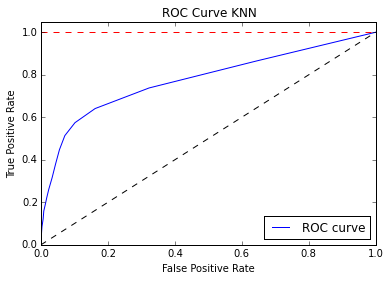

In [844]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve KNN')
plt.legend(loc="lower right")
plt.show()

In [845]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_log[:,1])
roc_auc_log = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_log, pos_label = None, average = None)

(array([ 0.90811831,  0.64505119]),
 array([ 0.98579041,  0.20565832]),
 array([ 0.94536164,  0.31188119]),
 array([7319,  919]))

Populating the interactive namespace from numpy and matplotlib


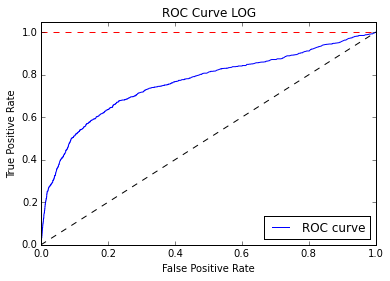

In [846]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve LOG')
plt.legend(loc="lower right")
plt.show()

In [847]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_gnb[:,1])
roc_auc_gnb = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_gnb, pos_label = None, average = None)

(array([ 0.91981199,  0.2925226 ]),
 array([ 0.88236098,  0.38737758]),
 array([ 0.90069735,  0.33333333]),
 array([7319,  919]))

Populating the interactive namespace from numpy and matplotlib


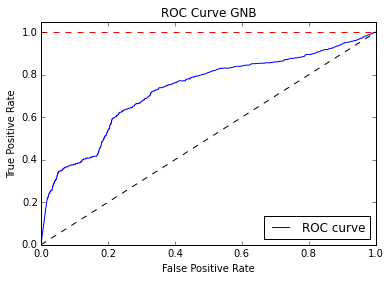

In [848]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve GNB')
plt.legend(loc="lower right")
plt.show()

In [849]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_svc[:,1])
roc_auc_svc = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_svc, pos_label = None, average = None)

(array([ 0.90800252,  0.62376238]),
 array([ 0.9844241 ,  0.20565832]),
 array([ 0.94467025,  0.30932897]),
 array([7319,  919]))

Populating the interactive namespace from numpy and matplotlib


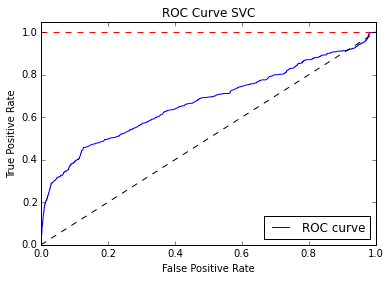

In [850]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVC')
plt.legend(loc="lower right")
plt.show()

In [851]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_dtc[:,1])
roc_auc_dtc = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_dtc, pos_label = None, average = None)

(array([ 0.91283574,  0.49392713]),
 array([ 0.96584233,  0.26550598]),
 array([ 0.93859125,  0.34536447]),
 array([7319,  919]))

Populating the interactive namespace from numpy and matplotlib


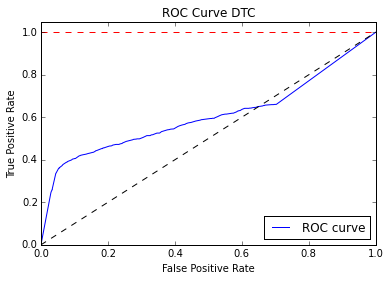

In [852]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve DTC')
plt.legend(loc="lower right")
plt.show()

In [853]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_rfc[:,1])
roc_auc_rfc = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_rfc, pos_label = None, average = None)

(array([ 0.9147036,  0.5078125]),
 array([ 0.96556907,  0.28291621]),
 array([ 0.93944832,  0.36338225]),
 array([7319,  919]))

Populating the interactive namespace from numpy and matplotlib


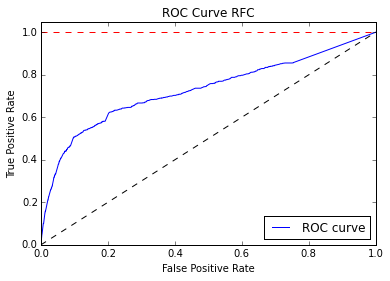

In [854]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve RFC')
plt.legend(loc="lower right")
plt.show()

In [855]:
roc_auc_knn

0.77625394337126341

In [856]:
roc_auc_log

0.76331298046537976

In [857]:
roc_auc_gnb

0.72996364493802623

In [858]:
roc_auc_svc

0.67139160064708525

In [859]:
roc_auc_dtc

0.60576672190867864

In [860]:
roc_auc_rfc

0.72840948945468309

In [861]:
X = X.astype(float)
cv = StratifiedKFold(y, n_folds=6)

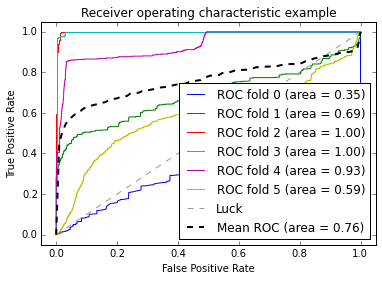

In [862]:
classifier = LogisticRegression()
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    # Compute ROC curve and area the curve
    probas_ = classifier.fit(X.iloc[train,:], y[train]).predict_proba(X.iloc[test,:])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:,1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

In [890]:
px2 = X_test.reshape((-1,9))
#'age','job','marital','contact','month','pdays','previous','poutcome','emp.var.rate','euribor3m'
X_err = pd.DataFrame({'age':px2[:,0],'job':px2[:,1],'marital':px2[:,2],'contact':px2[:,3],'pdays':px2[:,4],'previous':px2[:,5],'poutcome':px2[:,6],'emp.var.rate':px2[:,7],'euribor3m':px2[:,8]})

In [893]:
y_err = y_pred_log - y_test

In [895]:
indneg = []
indpos = []
for r in range(len(y_err)):
    if y_err[r] == 1:
        indpos.append(r)
    if y_err[r] == -1:
        indneg.append(r)

print len(indneg), len(indpos)

730 104


In [897]:
X_err_neg = X_err.iloc[indneg,:]

In [899]:
X_err_neg.head(5)

,age,contact,emp.var.rate,euribor3m,job,marital,pdays,poutcome,previous
0,0,1,0.000000,0.098727,0,0,0,0,0
8,0,1,0.000000,0.098545,0,0,0,0,0
24,0,1,0.520833,0.810727,1,0,0,0,0
39,0,1,0.520833,0.840364,0,0,0,0,0
49,0,1,0.312500,0.268909,0,0,0,0,0


In [906]:
sum(X_err_neg)

age               0.000000
contact         730.000000
emp.var.rate    362.312500
euribor3m       400.562727
job             100.000000
marital           0.000000
pdays             0.000000
poutcome         47.500000
previous         16.571429
dtype: float64

In [905]:
mean(X_err_neg)

age             0.000000
contact         1.000000
emp.var.rate    0.496318
euribor3m       0.548716
job             0.136986
marital         0.000000
pdays           0.000000
poutcome        0.065068
previous        0.022701
dtype: float64